In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve

In [38]:
df = pd.read_csv('Hotel_Reservations_clean.csv')
df.head(3)

,index,Booking_ID,num_adults,num_children,weekend_nights,week_nights,total_nights,meal_plan,car_parking,room_type,...,num_prev_not_canceled,avg_price_room,num_sp_requests,booking_status,meal_plan_cod,room_type_cod,mkt_segment_cod,arrival_season_cod,booking_status_cod,is_outlier
0,0,INN00001,2,0,1,2,3,Meal Plan 1,0,Room_Type 1,...,0,65.00,0,No cancelada,1,1,3,3,0,1
1,1,INN00002,2,0,2,3,5,Not Selected,0,Room_Type 1,...,0,106.68,1,No cancelada,0,1,4,1,0,1
2,2,INN00003,1,0,2,1,3,Meal Plan 1,0,Room_Type 1,...,0,60.00,0,Cancelada,1,1,4,1,1,1


In [56]:
#FUNCION PARA GRAFICAR CURVA ROC
def plot_roc_curve(y_test , y_prob):
    mpl.style.use('ggplot')
    false_positive_rate, true_positive_rate, _threshold = roc_curve(y_test, y_prob)
    sns.lineplot(x=false_positive_rate, y=true_positive_rate)
    plt.plot([0, 1], ls="--")
    plt.title('Curva ROC')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.tight_layout()
    plt.show()
    mpl.style.use('default')

### Pre-Procesamiento

#### Codificacion de variables cualitativas

In [39]:
var_dummy = pd.get_dummies(df.mkt_segment, dtype=int)
var_dummy.head(3)

,Aviation,Complementary,Corporate,Offline,Online
0,0,0,0,1,0
1,0,0,0,0,1
2,0,0,0,0,1


### Feature engineering

In [40]:
#SE ESTANDARIZAN VARIABLES (µ=0; σ=1)
scaler = StandardScaler()
date_vars = scaler.fit_transform(df[['arrival_day', 'arrival_month']])

#REDUCCION DE DIMENSIONALIDAD
pca = PCA(n_components=1)
reduce_vars = pca.fit_transform(date_vars)
reduce_vars = pd.Series(reduce_vars.flatten(), name='reduce_var')

#RESULTADO
print(f'Varianza explicada por la variable reducida: {pca.explained_variance_ratio_}')

Varianza explicada por la variable reducida: [0.52167988]


In [41]:
#SE ESTANDARIZAN VARIABLES (µ=0; σ=1)
std_vars = pd.DataFrame(StandardScaler().fit_transform(df[['lead_time', 'avg_price_room']]),
                        columns=['lead_time', 'avg_price_room'])

#RESULTADO
std_vars.head(3)

,lead_time,avg_price_room
0,1.615007,-1.389052
1,-0.932939,0.149398
2,-0.979477,-1.573607


In [42]:
#SELECCION DE VARIABLES PARA EL ENTRENAMIENTO
vars = ['num_sp_requests','car_parking', 'meal_plan_cod', 'num_adults',
        'num_children','weekend_nights', 'week_nights','room_type_cod']

x = pd.concat([df[vars], std_vars, reduce_vars,var_dummy], axis=1)

y = df.booking_status_cod

### Model Train

#### Entrenamiento

In [43]:
#SPLIT DE LOS DATOS PARA ENTRENAR Y VALIDAR
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y, random_state=42)

#INSTANCIA Y ENTRENAMIENTO DEL MODELO
model = RandomForestClassifier(max_depth=18, max_features=0.5, n_estimators=300, random_state=42)
model.fit(X_train, y_train)

#PREDICCION
y_pred = model.predict(X_test)

#### Metricas

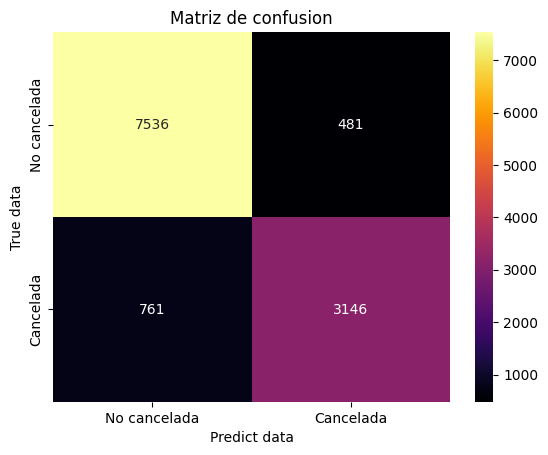

In [44]:
matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, fmt='.0f', annot=True, cmap='inferno')
plt.title('Matriz de confusion')
plt.xlabel('Predict data')
plt.xticks(ticks=[0.5,1.5], labels=['No cancelada', 'Cancelada'])
plt.ylabel('True data')
plt.yticks(ticks=[0.5,1.5], labels=['No cancelada', 'Cancelada'])
plt.show()

In [46]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      8017
           1       0.87      0.81      0.84      3907

    accuracy                           0.90     11924
   macro avg       0.89      0.87      0.88     11924
weighted avg       0.89      0.90      0.89     11924



In [48]:
y_prob = model.predict_proba(X_test)[:,1]
print(f'Score curva ROC: {roc_auc_score(y_test, y_prob)}')

Score curva ROC: 0.9514718674825211


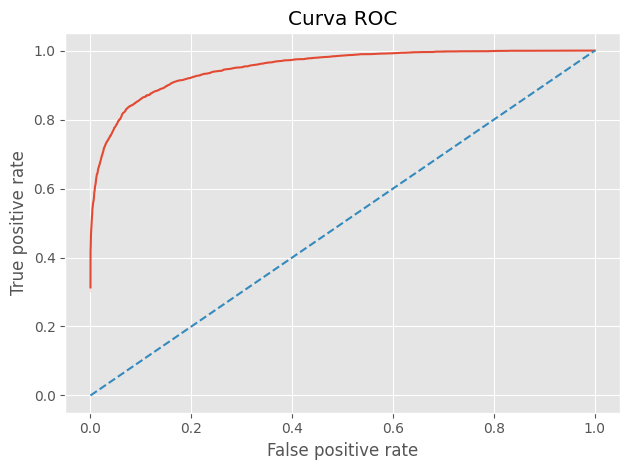

In [57]:
plot_roc_curve(y_test, y_prob)